<a href="https://colab.research.google.com/github/Stan081/ML/blob/main/Malaria_classification_FunctionalAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, AUC, F1Score
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Load dataset from tensorflow dataset repo. Also shuffle the dataset to add a level of randomness to it.
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
dataset
# The tfds.load method returns a list for the dataset which contains other elements aside the actual dataset, so to get the actual dataset, we take the first element in the list
dataset = dataset[0]

In [ ]:
# Perform a split on the dataset to get train, validation and test dataset.
def dataset_split(dataset:list, train_ratio, validation_ratio):
  '''
    input:
      dataset : list of data items (images)
      train_ratio, validation_ratio are decimal values which show the percentage of the dataset to be taken.

    returns:
      train_data : set split for training purpose.
      validation_split : set split for validation purpose.
      test_split : set split for testing purpose.
  '''
  # Get the size of the entire dataset
  dataset_size = len(dataset)

  # Take first percentage of the data
  train_data = dataset.take(int(train_ratio * dataset_size))

  # skip the already taken data
  val_test_split = dataset.skip(int(train_ratio * dataset_size))

  #Take the next percentage of the left over data after first split
  validation_data = val_test_split.take(int(validation_ratio * dataset_size))

  # Take the remainder for test
  test_data = val_test_split.skip(int(validation_ratio * dataset_size))

  return train_data, validation_data, test_data

In [ ]:
train_set, validation_set, test_set = dataset_split(dataset, 0.7, 0.2)

VISUALIZING THE DATA.

In [ ]:
for i, (image, label) in enumerate(validation_set.take(16)):
  ax = plt.subplot(4,4,i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

PROCESSING

In [ ]:
size = 224
def resize_and_rescale(image, label):
  """
    The method takes an image and resizes it to the desired dimension and the rescales the pixel values of the image to range from 0 to 1 instead of 0 to 255
    input:
      image: image to be resized
      label: label of the image
      size: dimension of the image (size X size)
    returns:
      Resized image and the label
  """
  return tf.image.resize(image, (size, size))/255.0, label

In [ ]:
train_set = train_set.map(resize_and_rescale)
validation_set = validation_set.map(resize_and_rescale)
test_set = test_set.map(resize_and_rescale)

In [ ]:
for (image, label) in train_set.take(1):
  print (image, dataset_info.features['label'].int2str(label) )

In [ ]:
train_set = train_set.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
validation_set = validation_set.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
train_set

In [ ]:
# Defining the input shape
func_input = Input(shape = (size, size, 3), name="Input Image")

**Model Creation (Functional):**
Functional API allows us to create models in multiple ways, we can create a model using the Sequential API and pass the model output into another set of layers using the functional API.

In [ ]:
# Feature Extractor Unit
# Difining the layers that make up the feature extraction unit
x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
feature_output = MaxPool2D(pool_size=2, strides=2)(x)

#Initializing the feature extraction unit
feature_unit = Model(func_input, feature_output, name='Feature_Extractor')

In [ ]:
feature_unit.summary()

In [ ]:
# Alternatively using sequential api
feature_extraction_seq = tf.keras.Sequential([
      InputLayer(input_shape = (size, size, 3)),

      Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
      BatchNormalization(),
      MaxPool2D(pool_size=2, strides=2),

      Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
      BatchNormalization(),
      MaxPool2D(pool_size=2, strides=2),

      Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'),
      BatchNormalization(),
      MaxPool2D(pool_size=2, strides=2)
])

In [ ]:
feature_extraction_seq.summary()

**Model Subclassing:**
This allows us to create recursively composable layers and models. This simply means we can create layers whose attributes are other laters. The main layer gets to track the parameters (weights and biases) of the sub layers.

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_3 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_3 = BatchNormalization()
    self.pool_3 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    x = self.conv_3(x)
    x = self.batch_3(x)
    x = self.pool_3(x)

    return x


In [ ]:
feature_unit_subclassed = FeatureExtractor(16,3,1,'valid', 'relu', 2)

CUSTOM MODELLLING

In [ ]:
class NeuralLearnDense(Layer):
  def __init__(self, output_units, activation):
    super().__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), trainable = True, initializer = "random_normal")
    self.b = self.add_weight(shape = (self.output_units,), trainable = True, initializer = "random_normal")

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if (self.activation == 'relu'):
      return tf.nn.relu(pre_output)
    elif (self.activation == 'sigmoid'):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [ ]:
# Classification Unit
#x = feature_unit(func_input)
#OR
# x = feature_extraction_seq(func_input)
#OR
x = feature_unit_subclassed(func_input)

x = Flatten()(x)

x = Dense(1000, activation='relu')(x)
# OR Using out custom built dense layer
# x = NeuralLearnDense(1000, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(1000, activation='relu')(x)
# x = NeuralLearnDense(1000, activation='relu')(x)
x = BatchNormalization()(x)

class_output = Dense(1, activation='sigmoid')(x)
# x = NeuralLearnDense(1, activation='sigmoid')(x)
model = Model(func_input, class_output, name='Classifier')

In [ ]:
model.summary()

In [ ]:
metrics = [BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), FalsePositives(name='fp'), FalseNegatives(name='fn'), TruePositives(name='tp'), TrueNegatives(name='tn'), AUC(name='auc')]

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=metrics)

In [ ]:
history = model.fit(train_set, validation_data = validation_set, epochs=5, verbose=1)

Epoch 1/5
603/603 [==============================] - 61s 100ms/step - loss: 0.1297 - accuracy: 0.9587 - precision: 0.9479 - recall: 0.9707 - fp: 514.0000 - fn: 282.0000 - tp: 9353.0000 - tn: 9141.0000 - auc: 0.9868 - val_loss: 0.2956 - val_accuracy: 0.9401 - val_precision: 0.9170 - val_recall: 0.9686 - val_fp: 243.0000 - val_fn: 87.0000 - val_tp: 2685.0000 - val_tn: 2496.0000 - val_auc: 0.9740
Epoch 2/5
603/603 [==============================] - 46s 76ms/step - loss: 0.1195 - accuracy: 0.9598 - precision: 0.9492 - recall: 0.9715 - fp: 501.0000 - fn: 275.0000 - tp: 9363.0000 - tn: 9151.0000 - auc: 0.9885 - val_loss: 0.8054 - val_accuracy: 0.9046 - val_precision: 0.9490 - val_recall: 0.8569 - val_fp: 128.0000 - val_fn: 398.0000 - val_tp: 2383.0000 - val_tn: 2602.0000 - val_auc: 0.9751
Epoch 3/5
603/603 [==============================] - 51s 85ms/step - loss: 0.1149 - accuracy: 0.9631 - precision: 0.9522 - recall: 0.9752 - fp: 472.0000 - fn: 239.0000 - tp: 9396.0000 - tn: 9183.0000 - auc:

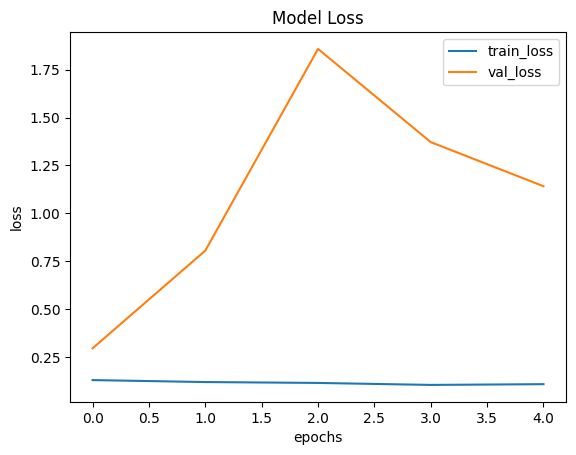

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

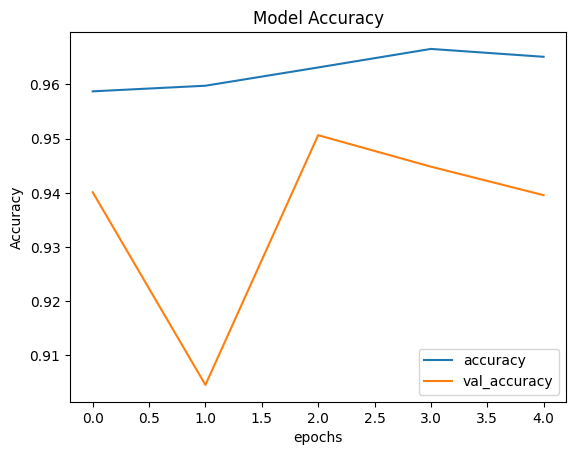

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
test_set = test_set.batch(5)


In [ ]:
len(test_set)

552

In [ ]:
model.evaluate(test_set)

In [ ]:
def cell_state(x):
  if(x < 0.7):
    return str('P')
  else:
    return str('U')

In [ ]:
cell_state(model.predict(test_set.take(1))[0][0])

In [ ]:
model.predict(test_set.take(1))

In [ ]:
for i, (image, label) in enumerate(test_set.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(cell_state(label.numpy()[0])) + ':' + str(cell_state(model.predict(image)[0][0])))
  plt.axis('off')

In [ ]:
# mal_model = model.save("models/malaria_model/")

Confusion Matrix

In [ ]:
labels = [y for x,y in test_set.as_numpy_iterator()]
inp = [x for x,y in test_set.as_numpy_iterator()]

In [ ]:
print(len(labels))

552


In [ ]:
predicted = model.predict(test_set)

552/552 [==============================] - 15s 7ms/step


In [ ]:
print(len(predicted[:552,0]))

552


In [ ]:
threshold = 0.5
cm = confusion_matrix(labels, predicted[:552,0] > threshold)
print(cm)

ValueError: Classification metrics can't handle a mix of unknown and binary targets